In [274]:
import numpy as np
import torch
from torchsummary import summary
import os

import sys
sys.path.insert(1, 'src')

from network import BF_CNN
# from universal_inverse_solve import universal_inverse_solver

## Load Denoiser

In [275]:
# Load the denoiser architecture
denoiser = BF_CNN()

# Use GPU if available
if torch.cuda.is_available():
    denoiser = denoiser.cuda()

# Load the learned parameters
denoiser_path = os.path.join('denoisers','mnist.pt')

if torch.cuda.is_available():
    learned_params = torch.load(denoiser_path)
else:
    learned_params = torch.load(denoiser_path, map_location='cpu')

denoiser.load_state_dict(learned_params)

denoiser.eval()

# Show summary of the denoiser
summary(denoiser, (1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
├─ModuleList: 1                          []                        --
|    └─Conv2d: 2-1                       [-1, 64, 28, 28]          576
|    └─Conv2d: 2-2                       [-1, 64, 28, 28]          36,864
|    └─Conv2d: 2-3                       [-1, 64, 28, 28]          36,864
|    └─Conv2d: 2-4                       [-1, 64, 28, 28]          36,864
|    └─Conv2d: 2-5                       [-1, 64, 28, 28]          36,864
|    └─Conv2d: 2-6                       [-1, 64, 28, 28]          36,864
|    └─Conv2d: 2-7                       [-1, 64, 28, 28]          36,864
|    └─Conv2d: 2-8                       [-1, 64, 28, 28]          36,864
|    └─Conv2d: 2-9                       [-1, 64, 28, 28]          36,864
|    └─Conv2d: 2-10                      [-1, 64, 28, 28]          36,864
|    └─Conv2d: 2-11                      [-1, 64, 28, 28]          36,864
|    └─Conv2d: 2-12                      [-1

Layer (type:depth-idx)                   Output Shape              Param #
├─ModuleList: 1                          []                        --
|    └─Conv2d: 2-1                       [-1, 64, 28, 28]          576
|    └─Conv2d: 2-2                       [-1, 64, 28, 28]          36,864
|    └─Conv2d: 2-3                       [-1, 64, 28, 28]          36,864
|    └─Conv2d: 2-4                       [-1, 64, 28, 28]          36,864
|    └─Conv2d: 2-5                       [-1, 64, 28, 28]          36,864
|    └─Conv2d: 2-6                       [-1, 64, 28, 28]          36,864
|    └─Conv2d: 2-7                       [-1, 64, 28, 28]          36,864
|    └─Conv2d: 2-8                       [-1, 64, 28, 28]          36,864
|    └─Conv2d: 2-9                       [-1, 64, 28, 28]          36,864
|    └─Conv2d: 2-10                      [-1, 64, 28, 28]          36,864
|    └─Conv2d: 2-11                      [-1, 64, 28, 28]          36,864
|    └─Conv2d: 2-12                      [-1

# Synthesis

In [276]:
import numpy as np
import torch
from abc import ABC, abstractmethod


class Task(ABC):
     
    @abstractmethod
    def M_T(self):
        pass
     
    @abstractmethod
    def M(self):
        pass


class Synthesis(Task):
        
    def M_T(self):
        return lambda x: torch.zeros_like(x)
    
    def M(self):
        return lambda x: torch.zeros_like(x)
            

def universal_inverse_solver(x_c: torch.Tensor, denoiser: BF_CNN, task: Task, sigma_0=1, sigma_L=0.01, h_0=0.01, beta=0.01) -> [torch.Tensor]:

    # M and M_T depend on the task we are performing, so input them as arguments depending on the task (ex infill)

    t = 1

    M = task.M()
    M_T = task.M_T()

    # N is the number of pixels in the image
    N = x_c.shape[2] * x_c.shape[1]

    # e is a matrix of 1's the shape of x_c
    e = torch.ones_like(M(x_c), requires_grad= False)

    # Draw y_0 from N(0.5 * (I - M^T M) e + M * x_c , sigma_0^2 * I)
    # y_t = torch.normal(0.5 * (torch.eye(x_c.shape[0]) - M_T(M(e))) + M(x_c), sigma_0 ** 2 * torch.eye(x_c.shape[0]))
    y_t = torch.normal((e - M(M_T(e)))/2 + M(x_c), sigma_0)
    y_t = y_t.unsqueeze(0)
    y_t.requires_grad = False

    f = denoiser(y_t)
    sigma = torch.norm(f)/np.sqrt(N)

    progress_imgs = []

    while sigma > sigma_L:

        # Save the progress of the image every 30 iterations
        if t % 30 == 0:
            progress_imgs.append(y_t - denoiser(y_t))
        
        # Step size
        h_t = h_0 * t / (1 + h_0 * (t - 1))

        # Denoised image
        #  f(y_t) = x^ (y) - y
        # Denoised is the output of the denoiser - the original image
        f = denoiser(y_t)

        # d_t = (I - M M^T) f(y_t) + M (x_c - M^T y_t) 
        d_t = f - M(M_T(f[0])) + M(M_T(y_t[0])) - M(x_c)

        # sigma_t = sqrt(abs(d_t)^2/N)

        sigma = torch.norm(d_t)/np.sqrt(N)

        # gamma_t = sqrt((1 beta * h_t)^2 - (1 - h_t)^2) * sigma_t^2)
        gamma_t = np.sqrt((1 - beta * h_t) ** 2 - (1 - h_t) ** 2) * sigma

        # Draw z_t from N(0, I)
        # z_t = torch.normal(0, 1)
        z_t = torch.randn(1, x_c.shape[2], x_c.shape[1])

        y_t = y_t - h_t * d_t + gamma_t * z_t

        t += 1

    progress_imgs.append(y_t - denoiser(y_t))

    return progress_imgs



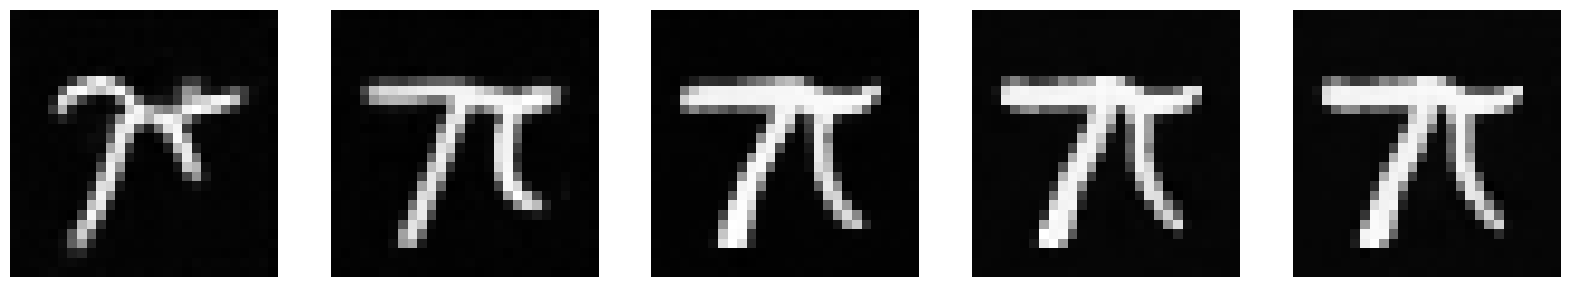

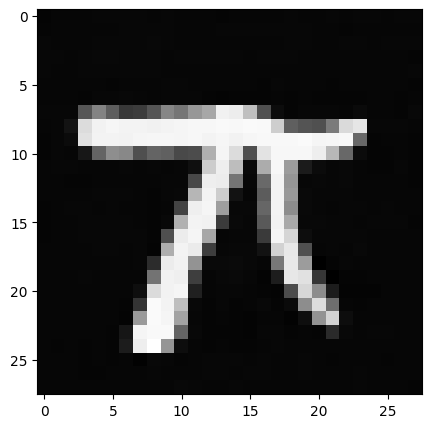

In [277]:
import matplotlib.pyplot as plt


# For synthesis, both M and M_T are zero like or shape sample image
# Images are mnist, so 28x28
# Create a Tensor of zeros with the same shape as the sample image

# Input image is 28x28 of zeros and noise will be added to it
# This will be synthesized by the denoiser
patch_size = (1, 28, 28) # 1 channel, 28x28
x_c = torch.zeros(patch_size) 

synth_images = universal_inverse_solver(x_c, denoiser, Synthesis())

# Reshape the synthesized image to be 28x28
synth_images = [synth.view(1,1,28,28) for synth in synth_images]

# Show synthesized images
fig, axs = plt.subplots(1, len(synth_images), figsize=(20, 20))
for i, img in enumerate(synth_images):
    axs[i].imshow(img[0,0,:,:].detach().numpy(), cmap='gray')
    axs[i].axis('off')

# Show last synthesized image
plt.figure(figsize=(5, 5))
plt.imshow(synth_images[-1][0,0,:,:].detach().numpy(), cmap='gray')

## Load Sample Image

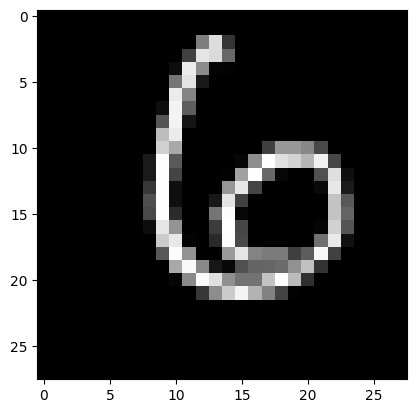

In [278]:
# Now load an image from the dataset and display it

import gzip
import random

def load_img(image_number=random.randint(0,1000)):
    f = gzip.open('data/t10k-images-idx3-ubyte.gz','r')
    f.read(16)
    buf = f.read(28 * 28 *10000)
    data = np.frombuffer(buf, dtype=np.uint8).astype(float)/255
    x = torch.tensor(data.reshape( 10000,28, 28).astype('float32'))[image_number:image_number+1]

    return x

x = load_img()

plt.imshow(x[0,:,:].detach().numpy(), cmap='gray')


## Corrupt Sample Image By Removing Rectangular Patches

Position: (10, 8), Dimensions: (12, 7)


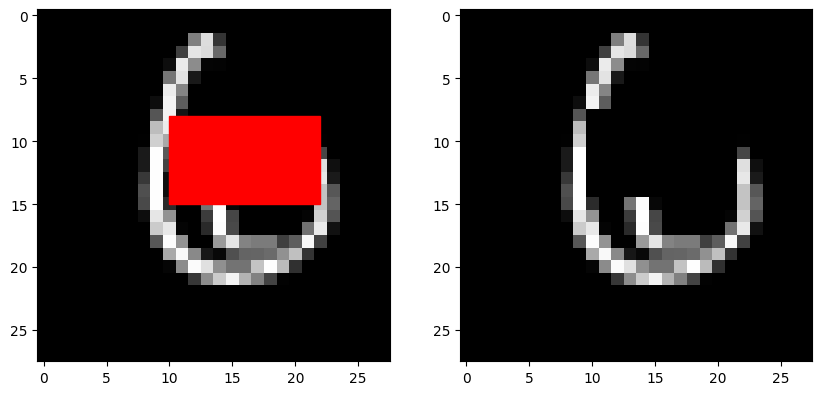

In [279]:
import matplotlib

# Random location on image
half_image_size = 28/2
quarter_image_size = 28/4

# Place rectangle in roughly center of image
rectangle_pos = (random.randint(quarter_image_size,half_image_size-1), random.randint(quarter_image_size,half_image_size-1))

# Random size rectangle
min_ = 6
max_ = 12
rectangle_dimensions = (random.randint(min_,max_), random.randint(min_,max_))

print(f'Position: {rectangle_pos}, Dimensions: {rectangle_dimensions}')

fig, ax = plt.subplots(1, 2, figsize=(10,10))

# Plot the image with the rectangle in red
ax[0].imshow(x[0,:,:].detach().numpy(), cmap='gray')

# 2x2 rectangle at 5,5
ax[0].add_patch(matplotlib.patches.Rectangle(rectangle_pos, rectangle_dimensions[0], rectangle_dimensions[1], color='red'))

# Create a mask of zeros with the same size as the image
mask = torch.ones_like(x)

# Set the mask to zero where the rectangle is
mask[0,rectangle_pos[1]:rectangle_pos[1]+rectangle_dimensions[1],rectangle_pos[0]:rectangle_pos[0]+rectangle_dimensions[0]] = 0

# Multiply the image by the mask to remove the rectangle
x_c = x * mask

# Plot the masked image
ax[1].imshow(x_c[0,:,:].detach().numpy(), cmap='gray')




## Inpaint Corrupted Image

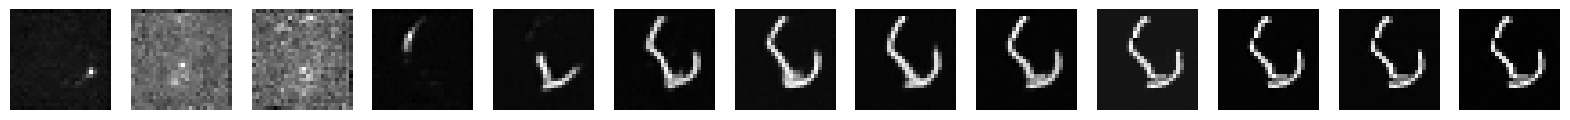

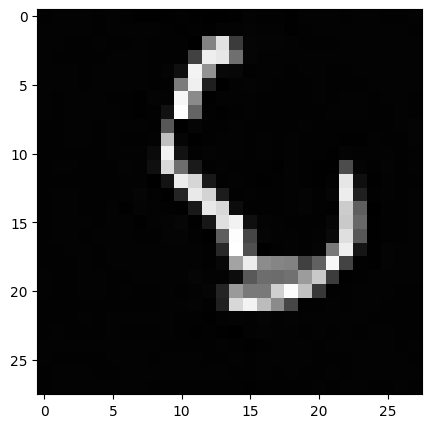

In [280]:
class Inpaint(Task):
    
    def __init__(self, x_c, rectangle_pos, rectangle_size):
        self.x_c = x_c
        self.mask = torch.ones(x_c.shape)

        # Half the height and width of the rectangle
        h, w = rectangle_size[0] // 2, rectangle_size[1] // 2

        # Center of the rectangle
        c1, c2 = rectangle_pos[0] + h, rectangle_pos[1] + w

        # Number of channels
        n_ch = x_c.shape[0]

        self.mask[0:n_ch, c1-h : c1+h , c2-w:c2+w] = 0

    def M_T(self):
        return lambda x: self.mask * x
    
    def M(self):
        return lambda x: self.mask * x
    

synth_images = universal_inverse_solver(x_c, denoiser, Inpaint(x_c, rectangle_pos, rectangle_dimensions))

# Reshape the synthesized image to be 28x28
synth_images = [synth.view(1,1,28,28) for synth in synth_images]

# Show synthesized images
fig, axs = plt.subplots(1, len(synth_images), figsize=(20, 20))
for i, img in enumerate(synth_images):
    axs[i].imshow(img[0,0,:,:].detach().numpy(), cmap='gray')
    axs[i].axis('off')

# Show last synthesized image
plt.figure(figsize=(5, 5))
plt.imshow(synth_images[-1][0,0,:,:].detach().numpy(), cmap='gray')

## Missing Random Pixels